In [56]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [57]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [58]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [59]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    N = y.shape[0]
    loss = 1 / (2 * N) * np.sum((y - tx.dot(w)) ** 2)
    return loss

# 2. Grid Search

Fill in the function `grid_search()` below:

In [60]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    for i in range(grid_w0.shape[0]):
        for j in range(grid_w1.shape[0]):
            losses[i, j] = compute_loss(y, tx, [grid_w0[i], grid_w1[j]])
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=15.428548387428222, w0*=73.57859531772576, w1*=13.545150501672254, execution time=3.589 seconds


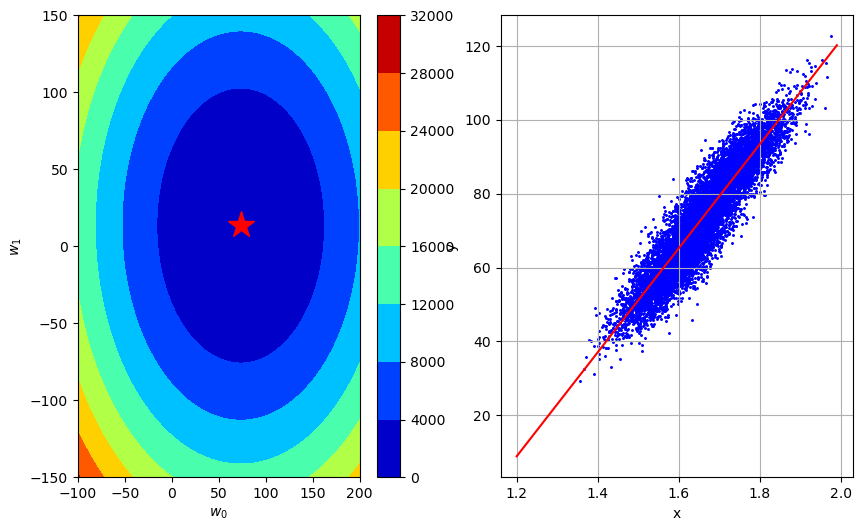

In [61]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)
grid_w0, grid_w1 = generate_w(num_intervals=50)
grid_w0, grid_w1 = generate_w(num_intervals=300)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving
plt.show()

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [62]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    N = y.shape[0]
    e = y - tx.dot(w)
    loss = -1 / N * (tx.T.dot(e))
    return loss

print(compute_gradient(np.array([y[0]]), np.array([tx[0, :]]), np.array([100, 20])))
# print(compute_gradient(y, tx, np.array([50, 10])))

[29.06155218 56.49744453]


Please fill in the functions `gradient_descent` below:

In [63]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters + 1 containing the model parameters as numpy arrays of shape (2, ),
            for each iteration of GD (as well as the final weights)
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y, tx, w)
        gradient = compute_gradient(y, tx, w)

        w = w - gamma * gradient

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [64]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
# gamma = 0.001
# gamma = 0.01
# gamma = 0.5
# gamma = 1
# gamma = 2
# gamma = 2.5

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.2367127591674, w0=51.305745401473644, w1=9.435798704492269
GD iter. 1/49: loss=265.3024621089598, w0=66.69746902191571, w1=12.266538315840005
GD iter. 2/49: loss=37.87837955044127, w0=71.31498610804834, w1=13.115760199244333
GD iter. 3/49: loss=17.410212120174467, w0=72.70024123388814, w1=13.370526764265632
GD iter. 4/49: loss=15.568077051450455, w0=73.11581777164007, w1=13.446956733772023
GD iter. 5/49: loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=15.386020684743531, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638307, w0=73.29348920882515, w1=13.47963283863509
GD iter. 10/49: loss=15.385887965652202, w0=73.29379216412117, w1=13.479688556082861
GD iter. 11/49: loss=15.385887877543452, w0=73.29388305070998, w1=13.47970527131

In [65]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)
    plt.show()


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [66]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    return compute_gradient(y, tx, w)


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    batches = batch_iter(y, tx, batch_size, max_iters)

    for n_iter in range(max_iters):
        yb, txb = next(batches)
        loss = compute_loss(yb, txb, w)
        gradient = compute_stoch_gradient(yb, txb, w)
        w = w - gamma * gradient

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [67]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=1535.0233762859084, w0=5.540800260406268, w1=-4.802345087307414
SGD iter. 1/49: loss=3067.576411487092, w0=13.373521896577302, w1=-0.8330161614799794
SGD iter. 2/49: loss=1042.728672349076, w0=17.9402026875875, w1=-4.801463591421773
SGD iter. 3/49: loss=3480.751123722016, w0=26.28376442550497, w1=7.627872317822676
SGD iter. 4/49: loss=795.7944475257051, w0=30.273236690167817, w1=2.7026046824979346
SGD iter. 5/49: loss=558.4472109381431, w0=33.61523373067561, w1=1.1418641208034996
SGD iter. 6/49: loss=388.89190458200517, w0=36.4041112990963, w1=0.5082927611267903
SGD iter. 7/49: loss=1203.8715529585559, w0=41.31098719513964, w1=1.3561586047249476
SGD iter. 8/49: loss=783.88709140985, w0=45.27050002226837, w1=-0.3125016999785162
SGD iter. 9/49: loss=1635.1865340247873, w0=50.98921759533454, w1=8.609485634850884
SGD iter. 10/49: loss=350.63500027119494, w0=53.637367894208055, w1=11.11993399867346
SGD iter. 11/49: loss=230.46270024118832, w0=55.78428522024177, w1=14.59

In [68]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)
    plt.show()


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [69]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=True, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [70]:
y.shape, tx.shape

((200,), (200, 2))

In [71]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2829.2722244384163, w0=51.54259072181176, w1=10.132993413506084
GD iter. 1/49: loss=267.0500258779429, w0=67.0053679383553, w1=13.172891437557825
GD iter. 2/49: loss=36.45002800750046, w0=71.64420110331838, w1=14.084860844773322
GD iter. 3/49: loss=15.696028199160635, w0=73.03585105280729, w1=14.358451666937965
GD iter. 4/49: loss=13.828168216410077, w0=73.45334603765397, w1=14.440528913587356
GD iter. 5/49: loss=13.660060817962522, w0=73.57859453310797, w1=14.46515208758217
GD iter. 6/49: loss=13.644931152102243, w0=73.61616908174418, w1=14.472539039780616
GD iter. 7/49: loss=13.643569482174817, w0=73.62744144633503, w1=14.474755125440149
GD iter. 8/49: loss=13.643446931881353, w0=73.63082315571229, w1=14.47541995113801
GD iter. 9/49: loss=13.643435902354941, w0=73.63183766852546, w1=14.475619398847368
GD iter. 10/49: loss=13.643434909697561, w0=73.63214202236942, w1=14.475679233160175
GD iter. 11/49: loss=13.643434820358397, w0=73.6322333285226, w1=14.475697183454

In [72]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)
    plt.show()


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [73]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    N = y.shape[0]
    loss = 1 / (2 * N) * np.sum(np.abs(y - tx.dot(w)))
    return loss


def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    N = y.shape[0]
    e = y - tx.dot(w)
    subgradient = -1 / N * tx.T.dot(np.sign(e))
    return subgradient

In [74]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y, tx, w)
        subgradient = compute_subgradient_mae(y, tx, w)

        w = w - gamma * subgradient

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [75]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=36.81613622986557, w0=0.7, w1=1.6895373988745632e-15
SubGD iter. 1/499: loss=36.46613622986557, w0=1.4, w1=3.3790747977491264e-15
SubGD iter. 2/499: loss=36.116136229865575, w0=2.0999999999999996, w1=5.068612196623689e-15
SubGD iter. 3/499: loss=35.76613622986558, w0=2.8, w1=6.758149595498253e-15
SubGD iter. 4/499: loss=35.41613622986557, w0=3.5, w1=8.447686994372816e-15
SubGD iter. 5/499: loss=35.06613622986557, w0=4.2, w1=1.013722439324738e-14
SubGD iter. 6/499: loss=34.716136229865576, w0=4.9, w1=1.1826761792121944e-14
SubGD iter. 7/499: loss=34.366136229865575, w0=5.6000000000000005, w1=1.3516299190996507e-14
SubGD iter. 8/499: loss=34.01613622986557, w0=6.300000000000001, w1=1.520583658987107e-14
SubGD iter. 9/499: loss=33.66613622986557, w0=7.000000000000001, w1=1.6895373988745633e-14
SubGD iter. 10/499: loss=33.31613622986558, w0=7.700000000000001, w1=1.8584911387620195e-14
SubGD iter. 11/499: loss=32.96613622986557, w0=8.4, w1=2.0274448786494757e-14
SubG

In [76]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)
    plt.show()


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [77]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    batches = batch_iter(y, tx, batch_size, max_iters)

    for n_iter in range(max_iters):
        yb, txb = next(batches)

        loss = compute_loss(yb, txb, w)
        subgradient = compute_subgradient_mae(yb, txb, w)

        w = w - gamma * subgradient

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [78]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=45.46976038672778, w0=0.7, w1=0.35170621708078426
SubSGD iter. 1/499: loss=45.741672697964695, w0=1.4, w1=1.2414988861476066
SubSGD iter. 2/499: loss=43.10793071642218, w0=2.0999999999999996, w1=1.47829292259873
SubSGD iter. 3/499: loss=39.338643081455366, w0=2.8, w1=1.6276620790223326
SubSGD iter. 4/499: loss=27.98255697990916, w0=3.5, w1=1.0507407942381344
SubSGD iter. 5/499: loss=44.66150787449272, w0=4.2, w1=2.1895024917923815
SubSGD iter. 6/499: loss=29.09067711798186, w0=4.9, w1=1.2088668887476404
SubSGD iter. 7/499: loss=25.155294093681587, w0=5.6000000000000005, w1=0.39490115681098703
SubSGD iter. 8/499: loss=25.84521231155447, w0=6.300000000000001, w1=0.2279345349317905
SubSGD iter. 9/499: loss=33.35598010793885, w0=7.000000000000001, w1=0.15542251156314496
SubSGD iter. 10/499: loss=42.571310605277645, w0=7.700000000000001, w1=1.2925056904898644
SubSGD iter. 11/499: loss=44.11118843835417, w0=8.4, w1=2.3808511821727913
SubSGD iter. 12/499: loss=28.3476

In [80]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    print(n_iter)
    fig.set_size_inches(10.0, 6.0)
    plt.show()


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=1, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_figure(n_iter)>